**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [ ]:
! pip install lightning torchmetrics torchinfo

3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [1]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*Missing logger folder.*")
warnings.filterwarnings("ignore", ".*You are using `torch.load` with `weights_only=False`.*")

# Prévision de la future consommation électrique

Nous allons travailler sur un jeu de données appelé [short-term electricity load forecasting](https://data.mendeley.com/datasets/byx7sztj59/1).
L'objectif est de prédire la consommation électrique au Panama pendant à un moment donné.
Les données disponibles vont du 3 janvier 2015 au 26 juin 2020 à l'échelle horaire (une observation toutes les heures) et incluent non la consommation d'électricité mais aussi des données météorologiques dans zones géographiques du Panama et des indicatrices pour les jours fériés et les jours d'école.

## (Télé)chargement des données

La fonction `load_dataset` permet de charger (et télécharger si besoin) le jeu de données dans un [`pandas.DataFrame()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [ ]:
import pandas as pd


def load_dataset(path='data'):
    """Load the dataset.

    Parameters
    ----------
    path : str
        Chemin du répertoire.

    Returns
    -------
    df : DataFrame
        Données.

    """
    import os
    from urllib.request import urlretrieve

    if not os.path.exists(path):
        os.makedirs(path)

    file = "continuous-dataset.csv"

    # Download the file if necessary
    if not os.path.isfile(os.path.join(path, file)):
        url = (
            'https://raw.githubusercontent.com/johannfaouzi/ensai-apprentissage-profond/'
            'main/data/electricity-load/continuous-dataset.csv'
        )
        urlretrieve(url, os.path.join(path, file))

    return pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=[0])

Il suffit d'exécuter la fonction pour (télé)charger les trois jeux de données :

In [3]:
df = load_dataset()

Visualisons le jeu de données :

In [4]:
df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1


Il y a $48\ 048$ observations et $16$ variables :
* `nat_demand` correspond à la consommation électrique nationale.
* `T2M_toc`, `T2M_san` et `T2M_dav` correspondent à la température à deux mètres à Tocumen, Santiago et David respectivement.
* `QV2M_toc`, `QV2M_san` et `QV2M_dav` correspondent à l'humidité à deux mètres à Tocumen, Santiago et David respectivement.
* `TQL_toc`, `TQL_san` et `TQL_dav` correspondent au niveau de précipitations à Tocumen, Santiago et David respectivement.
* `Holiday_ID` est un entier indiquant le type de jour férié (23 valeurs uniques)
* `holiday` est une variable binaire indiquant si le jour est férié ou non.
* `school` est une variable binaire indiquant si le jour est un jour d'école ou non.

L'objectif principal de ce notebook est d'illustrer l'utilisation de réseaux de neurones récurrents et non d'obtenir le meilleur modèle possible.
On va donc effectuer un prétraitement des données pour faciliter l'utilisation de réseaux de neurones récurrents.

On va tout d'abord supprimer la colonne `Holiday_ID`, non pas parce qu'elle n'est pas pertinente, mais simplement pour ne pas avoir à la traiter.
Afin de simplifier la tâche et d'enlever la saisonnalité journalière, on va également rééchantillonner le jeu de données et prendre la valeur moyenne des variables sur chaque journée.

In [5]:
df = df.drop('Holiday_ID', axis=1).resample('D').mean()
df

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,holiday,school
datetime,,,,,,,,,,,,,,,
2015-01-03,1069.266587,27.837319,0.018599,0.006561,22.589990,26.481001,0.018191,0.010949,11.127839,24.812523,0.017021,0.089999,4.377435,0.0,0.0
2015-01-04,1008.123596,27.385723,0.017987,0.003788,23.531261,26.250307,0.017811,0.013746,12.090789,24.195294,0.016846,0.104575,4.964404,0.0,0.0
2015-01-05,1146.682925,27.174477,0.017905,0.013344,26.775680,26.022784,0.017341,0.016091,14.204462,24.078774,0.016196,0.098414,7.180470,0.0,0.0
2015-01-06,1143.394429,27.003596,0.017390,0.010847,26.491710,25.909521,0.017176,0.015202,13.804753,23.811539,0.016012,0.096998,6.958897,0.0,0.0
2015-01-07,1144.098817,26.678420,0.017242,0.017465,23.896604,25.205438,0.016665,0.025092,13.041186,23.243199,0.015415,0.104125,6.984514,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23,1137.366342,28.212134,0.020796,0.064456,9.059754,27.373593,0.020025,0.071319,3.063794,25.106015,0.019313,0.140443,3.298566,0.0,1.0
2020-06-24,1131.196625,27.961924,0.019846,0.068500,6.366136,26.937836,0.019451,0.067418,4.563275,24.801768,0.018028,0.104188,2.209644,0.0,1.0
2020-06-25,1184.028708,27.874629,0.020355,0.037643,14.397304,27.097936,0.019417,0.117533,3.576064,25.025671,0.018032,0.187870,2.053162,0.0,1.0


Il ne reste plus que $2003$ observations et $15$ variables.

Visualisons la série temporelle dont on cherche à prédire les valeurs futures, c'est-à-dire `nat_demand` :

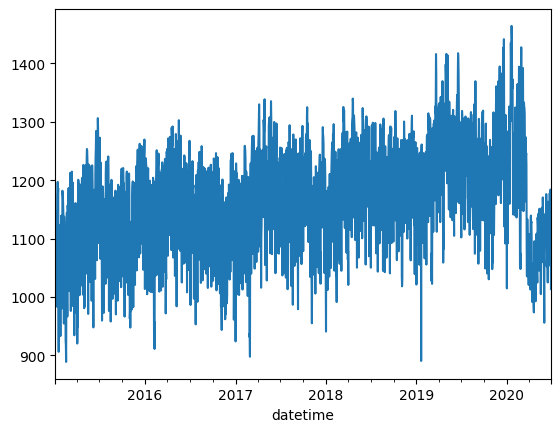

In [6]:
df['nat_demand'].plot();

On observe une chute de la consommation électrique peu après le début de l'année 2020, très probablement en lien avec la pandémie de Covid-19.
Pour éviter d'évaluer le modèle sur cette période, on va se limiter aux données jusqu'à la fin de l'année 2019.

In [7]:
df = df.loc[df.index.year <= 2019]

In [8]:
df.shape

(1824, 15)

Le jeu de données final contient donc $1824$ observations et $15$ variables.

## Jeux d'entraînement, de validation et d'évaluation - Normalisation des données

La séparation du jeu complet en jeux d'entraînement, de validation et d'évaluation est naturellement différente pour des données temporelles car les observations ne sont pas indépendantes les unes des autres.
La séparation se fait également au niveau temporel.
Schématiquement, l'entraînement correspond au passé, la validation au présent et l'évaluation au futur.

Le `DataFrame` est déjà ordonné chronologiquement.
Il est donc nécessaire de définir deux dates limites pour séparer les jeux d'entraînement de validation d'une part, et les jeu de validation et d'évaluation d'autre part.
On va utiliser les années 2015 à 2017 pour le jeu d'entraînement, l'année 2018 pour le jeu de validation et l'année 2019 pour l'évaluation.

Vous avez probablement remarqué que les différentes variables dans le `DataFrame` n'ont pas les mêmes échelles : les variables pour la température ont par exemple des valeurs bien plus élevées que celles pour l'humidité et pour les précipitations.
De telles différences d'échelles peuvent compliquer l'entraînement d'un modèle d'apprentissage automatique, et c'est d'autant plus vrai pour un réseau de neurones.
On va donc normaliser les données.
Néanmoins, les jeux de validation et d'évaluation ne doivent pas servir pour l'entraînement, et l'estimation des paramètres utilisés pour la normalisation fait partie de l'entraînement.
Il est donc nécessaire de n'utiliser que les données d'entraînement pour estimer ces paramètres.
Les variables binaires n'ont pas besoin d'être modifiées.

Il est temps d'écrire le code pour effectuer ce travail.
Comme les données sont déjà ordonnées chronologiquement, il nous suffit de trouver les indices du premier jour des années 2018 et 2019 pour effectuer la sépration en trois jeux.

In [9]:
import numpy as np


# Indice correspondant au 1er janvier 2018
premier_jour_2018_idx = np.where(df.index.year == 2018)[0].min()

# Indice correspondant au 1er janvier 2019
premier_jour_2019_idx = np.where(df.index.year == 2019)[0].min()

In [10]:
from sklearn.preprocessing import MinMaxScaler
import torch


# On récupère les données sous la forme d'un tableau NumPy
X_numpy = df.to_numpy()

# On sépare les données à échelonner
X_numpy_to_scale = X_numpy[:, :-2]

# On échelonne ces données
scaler = MinMaxScaler(feature_range=(-1.0, 1.0))
scaler.fit(X_numpy_to_scale[:premier_jour_2018_idx])
X_numpy_scaled = scaler.transform(X_numpy_to_scale)

# On concatène les données échelonnées et les variables binaires
X_numpy_full = np.c_[X_numpy_scaled, X_numpy[:, -2:]]

# On transforme ce tableau NumPy en tenseur PyTorch
X = torch.from_numpy(X_numpy_full).to(dtype=torch.float32)

# On supprime les variables dont on n'a plus besoin
del X_numpy, X_numpy_to_scale, X_numpy_scaled, X_numpy_full

## Objets `Dataset` et `Dataloader`

Comme on a ici un jeu de données dans un contexte particulier (séries temporelles), on va devoir créer notre propre version de `Dataset`, c'est-à-dire créer notre propre classe héritant de la classe [`torch.utils.data.Dataset()`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).

Dans la documentation du jeu de données, il est recommandé d'avoir au moins $72$ heures d'écart entre les données d'entrée et les données de sortie.
En effet, il faut prévenir un minimum de temps à l'avance pour changer la future quantité d'électricité à produire.
Comme on a rééchantillonné les données horaires en données journalières, l'écart minimum entre le dernier jour de l'entrée et le premier jour de la sortie est donc de $3$ jours.
La variable `time_gap` permet de définir l'écart (en nombre de jours) entre le dernier jour de l'entrée et le premier jour de la sortie, et sa valeur par défaut est $3$.

Il faut également définir la longueur des séries temporelles en entrée et en sortie.
La variable `output_length` détermine le nombre de jours pour lesquels on prédit la consommation électrique.
Concernant les sorties, on ne cherche pas à prédire la consommation électrique très en avance non plus.
On va donc la prédire pendant les $7$ prochains jours (après le délai défini par `time_gap`).
La variable `input_length` détermine le nombre de jours pour lesquels on fournit les données en entrée.
Le nombre de jours pourrait être variable : on a le droit d'utiliser toutes les données du passé pour prédire le futur.
Cependant, pour réduire la complexité de l'entraînement et faciliter la création de lots d'observations, on va utiliser un nombre fixe de jours, fixé à $30$, c'est-à-dire un mois environ.
Une limite évidente de cette approche est qu'on ne modélise pas la saisonnalité annuelle.

La fonction `create_train_val_test_splits()` définie ci-dessous permet de créer les jeux d'entraînement, de validation et d'évaluation en fonction des valeurs fournies pour les différents arguments.

In [ ]:
from torch.utils.data import Dataset, DataLoader


def create_train_val_test_splits(
    X, train_val_split_idx, val_test_split_idx, input_length=30, output_length=7, time_gap=3
):
    """Crée les jeux d'entraînement, de validation et d'évaluation.

    Parameters
    ----------
    train_val_split_idx : int
        Indice séparant les jeux d'entraînement et de validation.

    val_test_split_idx : int
        Indice séparant les jeux de validation et d'évaluation.

    input_length : int (default = 30)
        Nombre de jours pour les séries temporelles en entrée.

    output_length : int (default = 7)
        Nombre de jours à prédire.

    time_gap : int (default = 3)
        Nombre de jours de séparation entre le dernier jour de l'entrée
        et le premier jour de la sortie.

    Returns
    -------
    dataset_train : Dataset
        Jeu d'entraînement

    dataset_val : Dataset
        Jeu de validation

    dataset_test : Dataset
        Jeu d'évaluation

    """

    class CustomDataset(Dataset):
        """
        Parameters
        ----------
        X : Tensor, shape = (n_samples, n_features)
            Données.

        dataset : {'training', 'validation', 'test'}
            Jeu de données considéré.
        """
        def __init__(self, X, dataset):
            if dataset not in ('training', 'validation', 'test'):
                raise ValueError("'dataset' doit être l'un de 'training', 'validation' ou 'test'.")
            self.X = X
            self.dataset = dataset

        def __len__(self):
            if self.dataset == 'training':
                return train_val_split_idx - (input_length + time_gap + output_length) + 1
            elif self.dataset == 'validation':
                return (val_test_split_idx - (train_val_split_idx + output_length)) // output_length + 1
            else:
                return (len(X) - (val_test_split_idx + output_length)) // output_length + 1

        def __getitem__(self, idx):
            if not (0 <= idx < len(self)):
                raise ValueError(
                    f"Indice non valide. La longueur du jeu de données est {len(self)}."
                )
            if self.dataset == 'training':
                start_idx = 0
                step = 1
            elif self.dataset == 'validation':
                start_idx = train_val_split_idx - input_length - time_gap
                step = output_length
            else:
                start_idx = val_test_split_idx - input_length - time_gap
                step = output_length

            start_idx_input = start_idx + idx * step
            end_idx_input = start_idx_input + input_length

            start_idx_output = end_idx_input + time_gap
            end_idx_output = start_idx_output + output_length

            return self.X[start_idx_input:end_idx_input], self.X[start_idx_output:end_idx_output, 0]

    return CustomDataset(X, 'training'), CustomDataset(X, 'validation'), CustomDataset(X, 'test')

On l'exécute pour créer les trois jeux de données, puis on crée les *dataloaders* pour chacun des jeux de données.

In [12]:
input_length = 30
output_length = 7
time_gap = 3

dataset_train, dataset_val, dataset_test = create_train_val_test_splits(
    X, premier_jour_2018_idx, premier_jour_2019_idx, input_length, output_length, time_gap
)

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=52, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=52, shuffle=False)

## Réseau de neurones récurrent

Il est enfin temps de créer notre réseau de neurones récurrent ! L'architecture de votre réseau sera l'architecture séquentielle suivante :
* Couche LSTM avec `lstm_hidden_size` variables dans l'état caché. On ne garde que le dernier état caché.
* Couche linéaire avec `linear_out_features` variables en sortie.
* Fonction d'activation ReLU
* Couche linéaire avec `output_length` variables en sortie (car on prédit pour les `output_length` prochains jours avec le saut de `time_gap` jours).

L'intérêt d'utiliser des paramètres pour ces variables est de pouvoir essayer différentes combinaisons sans avoir besoin de recréer une nouvelle classe à chaque fois.
Néanmoins, on donnera des valeurs par défaut aux paramètres : `lstm_hidden_size=256` et `linear_out_features=128`.

### Question 1

Complétez les méthodes `__init__()` et `forward()` de la classe `RecurrentNeuralNetwork` définie ci-dessous. Consultez la documentation de [`torch.nn.LSTM()`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) pour comprendre l'entrée attendue et la sortie renvoyée par cette couche.

Pour rappel, l'entrée renvoyée par le *dataloader*, c'est-à-dire l'entrée du modèle (l'argument `x` de la méthode `forward()`) est un tenseur de taille $(N, L, H_{in})$ où :
* $N$ est la taille du lot (argument `batch_size` du dataloader).
* $L$ est la longueur de chaque séquence (c'est-à-dire la variable `input_length` définie ci-dessus).
* $H_{in}$ est la dimension à chaque instant, c'est-à-dire le nombre de variables, soit $15$.

In [ ]:
import lightning as L
from torchmetrics import MeanSquaredError


class RecurrentNeuralNetwork(L.LightningModule):  # La classe hérite de la classe lightning.LightningModule
    def __init__(self, lstm_hidden_size=256, linear_out_features=128):
        """Constructeur.

        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère

        ### BEGIN TODO ###
        self.lstm = torch.nn.LSTM(input_size=15, hidden_size=lstm_hidden_size, batch_first=True)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features=256, out_features=linear_out_features),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=linear_out_features, out_features=output_length)
        )
        #### END TODO ####

        self.loss = MeanSquaredError()

    def forward(self, x):
        """Implémente la passe avant.

        L'argument x est un tenseur correspondant soit à l'entrée une seule
        observation soit aux entrées d'un lot d'observations.
        """
        ### BEGIN TODO ###
        _, (h_n, _) = self.lstm(x)
        y = self.mlp(torch.squeeze(h_n))
        ### END TODO ###
        return y

    def step(self, batch):
        """Effectue une étape.

        Une étape consiste à passer d'un lot d'observations (l'argument batch)
        à l'évaluation de la fonction de coût pour ce lot d'observations.

        Parameters
        ----------
        batch : tuple
            Un lot d'observations. Le premier élément du tuple est le lot
            des entrées, le second est le lot des labels.

        Returns
        -------
        loss : Tensor
            La fonction de coût pour ce lot d'observations.
        """
        X, y = batch  # X correspond aux entrées, y aux sorties attendues
        y_pred = self(X)  # Passe avant, qui renvoie les logits
        loss = self.loss(y_pred, y)  # Évaluation de la fonction de coût

        # Prédictions dans l'espace original
        y_cpu = y.cpu().detach()
        y_pred_cpu = y_pred.cpu().detach()
        y_rescaled = self.inverse_transform(y_cpu)
        y_pred_rescaled = self.inverse_transform(y_pred_cpu)
        mse_rescaled = self.loss(y_pred_rescaled, y_rescaled)

        return loss, mse_rescaled

    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        loss, mse_rescaled = self.step(batch)
        self.log("loss_train", loss, on_step=False, on_epoch=True)
        self.log("mse_train", mse_rescaled, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        loss, mse_rescaled = self.step(batch)
        self.log("loss_val", loss, on_step=False, on_epoch=True)
        self.log("mse_val", mse_rescaled, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch):
        """Effectue une étape d'évaluation."""
        loss, mse_rescaled = self.step(batch)
        self.log("loss_test", loss, on_step=False, on_epoch=True)
        self.log("mse_test", mse_rescaled, on_step=False, on_epoch=True)
        return loss

    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            ------------------------------------------------
            |     Jeu      | Fonction de perte |    MSE    |
            | ------------ | ----------------- | --------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|{metrics['mse_train'].item():^11.2f}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|{metrics['mse_val'].item():^11.2f}|
            ------------------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, "\n")

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    @staticmethod
    def inverse_transform(x):
        """Applique la transformation inverse pour la série temporelle à prédire.

        Paramters
        ---------
        x : Tensor, shape = (output_length,)
            Série temporelle échelonnée prédite.

        Returns
        -------
        x_new : Tensor, shape = (output_length,)
            Série temporelle prédite dans l'espace original.
        """
        return (
            (x - scaler.feature_range[0])
            /
            (scaler.feature_range[1] - scaler.feature_range[0])
            *
            (scaler.data_max_[0] - scaler.data_min_[0])
        ) + scaler.data_min_[0]

### Question 2

Affichez un résumé de votre réseau de neurones avec les valeurs par défaut. Combien de paramètres entraînables contient-il ?

In [14]:
from torchinfo import summary


summary(RecurrentNeuralNetwork(), input_size=(64, 30, 15))

Layer (type:depth-idx)                   Output Shape              Param #
RecurrentNeuralNetwork                   [64, 7]                   --
├─LSTM: 1-1                              [64, 30, 256]             279,552
├─Sequential: 1-2                        [64, 7]                   --
│    └─Linear: 2-1                       [64, 128]                 32,896
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 7]                   903
Total params: 313,351
Trainable params: 313,351
Non-trainable params: 0
Total mult-adds (M): 538.90
Input size (MB): 0.12
Forward/backward pass size (MB): 4.00
Params size (MB): 1.25
Estimated Total Size (MB): 5.37

**Réponse** : Le modèle contient $313\ 351$ paramètres entraînables avec les valeurs par défaut pour les deux hyperparamètres.

On va maintenant entraîner le modèle pendant `100` époques en exécutant le code ci-dessous.

In [15]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import TQDMProgressBar


model = RecurrentNeuralNetwork()

trainer = L.Trainer(
    max_epochs=100,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[TQDMProgressBar(refresh_rate=0)],  # on supprime la barre de progression
    log_every_n_steps=0,  # on ne sauvegarde les résultats qu'à la fin de chaque époque
)

trainer.fit(
    model=model,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Version 0


Époque 1 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.14583      |  7415.67  |
|  Validation  |      0.15912      |  8091.49  |
------------------------------------------------


Époque 2 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.13412      |  6819.90  |
|  Validation  |      0.11787      |  5993.87  |
------------------------------------------------


Époque 3 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.12432      |  6321.54  |
|  Validation  |      0.09635      |  4899.54  |
------------------------------------------------


Époque 4 / 100
----------------------------------------


Époque 28 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.01398      |  710.91   |
|  Validation  |      0.08096      |  4116.88  |
------------------------------------------------


Époque 29 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.01297      |  659.31   |
|  Validation  |      0.07860      |  3997.08  |
------------------------------------------------


Époque 30 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.01223      |  621.71   |
|  Validation  |      0.07749      |  3940.61  |
------------------------------------------------


Époque 31 / 100
-----------------------------------------------


Époque 55 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.00353      |  179.29   |
|  Validation  |      0.09012      |  4582.41  |
------------------------------------------------


Époque 56 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.00333      |  169.54   |
|  Validation  |      0.08773      |  4460.89  |
------------------------------------------------


Époque 57 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.00296      |  150.45   |
|  Validation  |      0.09465      |  4813.07  |
------------------------------------------------


Époque 58 / 100
-----------------------------------------------


Époque 82 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.00180      |   91.73   |
|  Validation  |      0.09425      |  4792.81  |
------------------------------------------------


Époque 83 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.00156      |   79.42   |
|  Validation  |      0.08166      |  4152.28  |
------------------------------------------------


Époque 84 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.00156      |   79.49   |
|  Validation  |      0.09014      |  4583.47  |
------------------------------------------------


Époque 85 / 100
-----------------------------------------------

### Question 3

Pour rappel, l'erreur quadratique moyenne est à la fois la fonction de perte (pour entraîner le modèle) et la métrique (pour évaluer le modèle).
Cependant, on a normalisé les données pour faciliter l'entraînement du modèle.
Pour la métrique, on va *dénormaliser* les prédictions pour les remettre dans l'espace original, puisque c'est celui qui importe en pratique.
C'est à cela que sert la méthode statique `inverse_transform()` de la classe `RecurrentNeuralNetwork()`.

Visualisez la performance du modèle sur les jeux d'entraînement et de validation grâce à la fonction `plot_loss_mse()` définie ci-dessous. Quel problème remarque-vous ?

In [ ]:
import matplotlib.pyplot as plt


def plot_loss_mse(savedir='.', version=None):
    """Affiche les courbes de la fonction de perte et d'accuracy.

    Parameters
    ----------
    savedir : str (default = '.')
        Chemin où les résultats sont sauvegardés.

    version : int or None (default = None)
        Numéro de la version du modèle.
    """
    # Récupère les résultats sous la forme d'un DataFrame
    import os
    if version is None:
        version = max([
            int(folder.split('version_')[1])
            for folder in os.listdir(os.path.join(savedir, 'lightning_logs'))
            if folder.startswith('version')
        ])
    df = pd.read_csv(os.path.join(savedir, 'lightning_logs', f'version_{version}', 'metrics.csv'))
    df['epoch'] += 1  # On commence à compter à partir de 1

    loss_train = df.dropna(subset='loss_train').set_index('epoch')['loss_train']
    loss_val = df.dropna(subset='loss_val').set_index('epoch')['loss_val']

    mse_train = df.dropna(subset='mse_train').set_index('epoch')['mse_train']
    mse_val = df.dropna(subset='mse_val').set_index('epoch')['mse_val']

    # Affiche les résultats
    plt.figure(figsize=(13, 4))

    plt.subplot(1, 2, 1)
    plt.plot(loss_train.index, loss_train.to_numpy(), '-', label='Entraînement');
    plt.plot(loss_val.index, loss_val.to_numpy(), '-', label='Validation');
    plt.xlabel('Époque')
    plt.ylabel('Fonction de coût')
    plt.yscale('log')
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot(mse_val.index, mse_train.to_numpy(), '-', label='Entraînement');
    plt.plot(mse_val.index, mse_val.to_numpy(), '-', label='Validation');
    plt.xlabel('Époque')
    plt.ylabel('Erreur quadratique moyenne')
    plt.yscale('log')
    plt.legend();

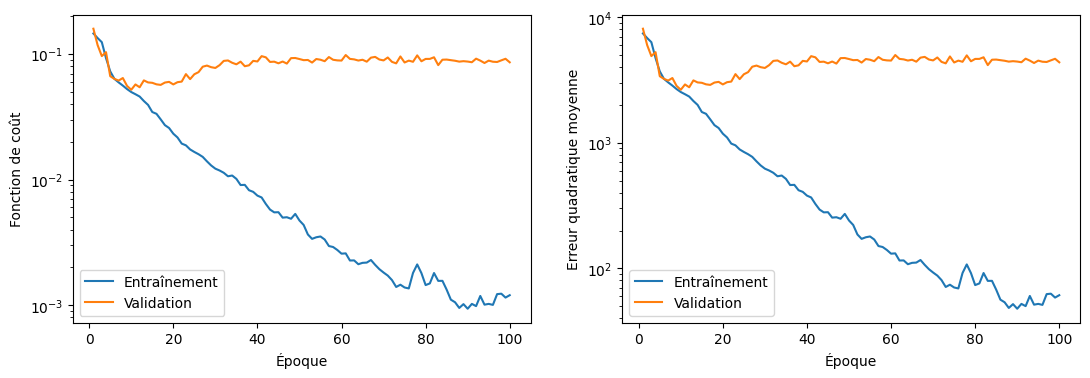

In [17]:
plot_loss_mse()

**Réponse** : Le modèle souffre grandement de surapprentissage : la performance sur le jeu d'entraînement est non seulement bien plus faible que sur le jeu de validation (phénomène qui commence dès la dixième époque à peu près), mais en plus la performance sur le jeu de validation à la dernière époque n'est pas la performance la plus faible sur le jeu de validation.

### Question 4

Affichez les prédictions du modèle et l'erreur quadratique moyenne sur les jeux d'entraînement et de validation grâce à la fonction `plot_true_pred()` définie ci-dessous :

In [ ]:
def plot_true_pred(model, dataset):
    """Affiche les vraies valeurs et les prédictions sur un jeu de données.

    Parameters
    ----------
    model : RecurrentNeuralNetwork
        Modèle entraîné.

    dataset : Dataset
        Jeu de données.
    """
    if dataset.dataset == 'training':
        step = 7
    else:
        step = 1

    # Calcule les prédictions
    X_ = torch.stack([dataset[i][0] for i in range(0, len(dataset), step)])
    y_pred = RecurrentNeuralNetwork.inverse_transform(
        model(X_).view(-1)
    ).detach().numpy()

    # Calcule les vraies valeurs
    y_true = RecurrentNeuralNetwork.inverse_transform(
        torch.cat([dataset[i][1] for i in range(0, len(dataset), step)])
    ).detach().numpy()

    if dataset.dataset == 'training':
        index = df.iloc[input_length+time_gap:premier_jour_2018_idx].index[:len(y_true)]
    elif dataset.dataset == 'validation':
        index = df.iloc[premier_jour_2018_idx:premier_jour_2019_idx].index[:len(y_true)]
    else:
        index = df.iloc[premier_jour_2019_idx:].index[:len(y_true)]

    df_temp = pd.DataFrame([index, y_true, y_pred]).T
    df_temp.columns = ['Date', 'Vraies valeurs', 'Prédictions']
    df_temp.set_index('Date', inplace=True)

    plt.figure(figsize=(20, 4))
    plt.plot(df_temp['Vraies valeurs'], label='Vraies valeurs')
    plt.plot(df_temp['Prédictions'], label='Prédictions')
    plt.legend()
    plt.title(f'Erreur quadratique moyenne = {((y_true - y_pred) ** 2).mean():.2f}')

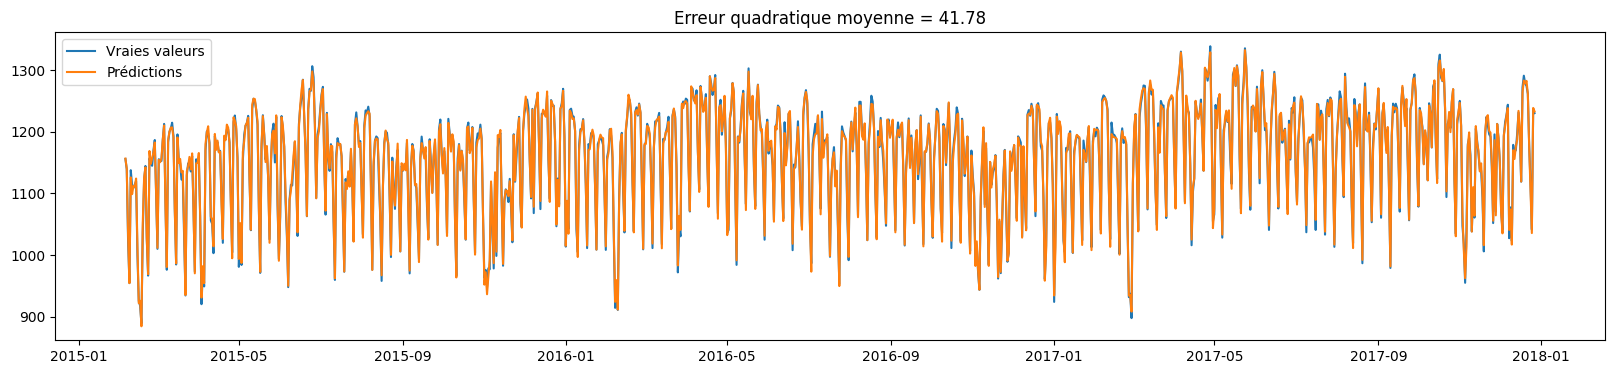

In [19]:
plot_true_pred(model, dataset_train)

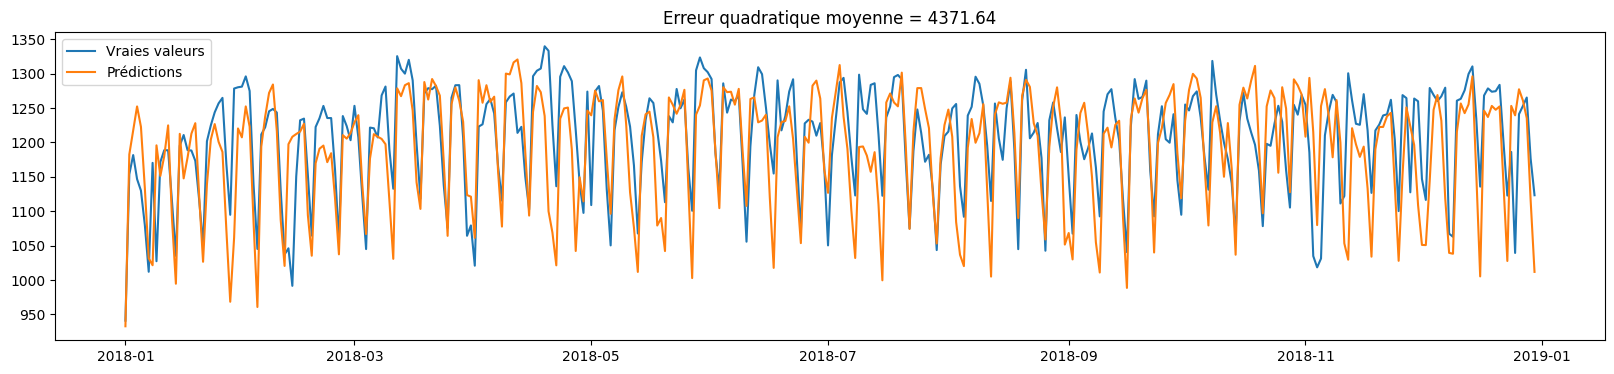

In [20]:
plot_true_pred(model, dataset_val)

Maintenant que l'on a remarqué que le modèle souffre de surapprentissage, il est temps de proposer une méthode pour l'éviter.
Une approche possible est d'effectuer de l'*early stoppping*, c'est-à-dire arrêter l'entraînement du modèle plus tôt.
Un critère d'arrêt classique est que la fonction de coût sur le jeu de validation ne diminue plus après $n$ époques, où $n$ est un hyperparamètre à définir.

Avec PyTorch Lightning, cette approche se définit dans le `Trainer`, et plus particulièrement grâce à l'argument `callbacks`.
On indique à PyTorch Lightning qu'on veut effectuer un arrêt anticipé en ajoutant une instance de [`lightning.pytorch.callbacks.early_stopping.EarlyStopping()`](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.EarlyStopping.html). Dans cet instance, on indique le score à surveiller (argument `monitor`), quel mode utiliser (argument `mode`, `"min"` si le score décroît quand le modèle est meilleur, `"max"` si le score croît quand le modèle est meilleur) et le nombre de vérifications (c'est-à-dire le nombre d'époques si on effectue une vérification seulement à la fin de chaque époque) sans amélioration (argument `patience`).
La patience est importante car il est possible d'avoir quelques époques où le modèle ne progresse plus, puis qu'il se remette à progresser ensuite.

Ici, le score à surveiller est la fonction de perte, qui décroît quand le modèle devient meilleur.
On utilise la valeur par défaut pour la patience, qui est de 3.
Exécutez le code ci-dessous :

In [21]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


model_early_stopping = RecurrentNeuralNetwork()

trainer_early_stopping = L.Trainer(
    max_epochs=100,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[
        TQDMProgressBar(refresh_rate=0),  # supprime la barre de progression
        EarlyStopping(monitor="loss_val", mode="min", patience=3)  # effectue de l'early stopping
    ],
    log_every_n_steps=0,  # on ne sauvegarde les résultats qu'à la fin de chaque époque
)

trainer_early_stopping.fit(
    model=model_early_stopping,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Version 1


Époque 1 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.14745      |  7498.09  |
|  Validation  |      0.13934      |  7085.42  |
------------------------------------------------


Époque 2 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.13437      |  6832.77  |
|  Validation  |      0.14805      |  7528.42  |
------------------------------------------------


Époque 3 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.12708      |  6462.11  |
|  Validation  |      0.10959      |  5572.51  |
------------------------------------------------


Époque 4 / 100
----------------------------------------

On remarque que l'entraînement s'arrête bien avant les $100$ époques.

### Question 5

Affichez la performance de ce modèle sur les jeux d'entraînement et d'évaluation grâce à la fonction `plot_true_pred()`.
Comparez-la à celle du modèle précédent.

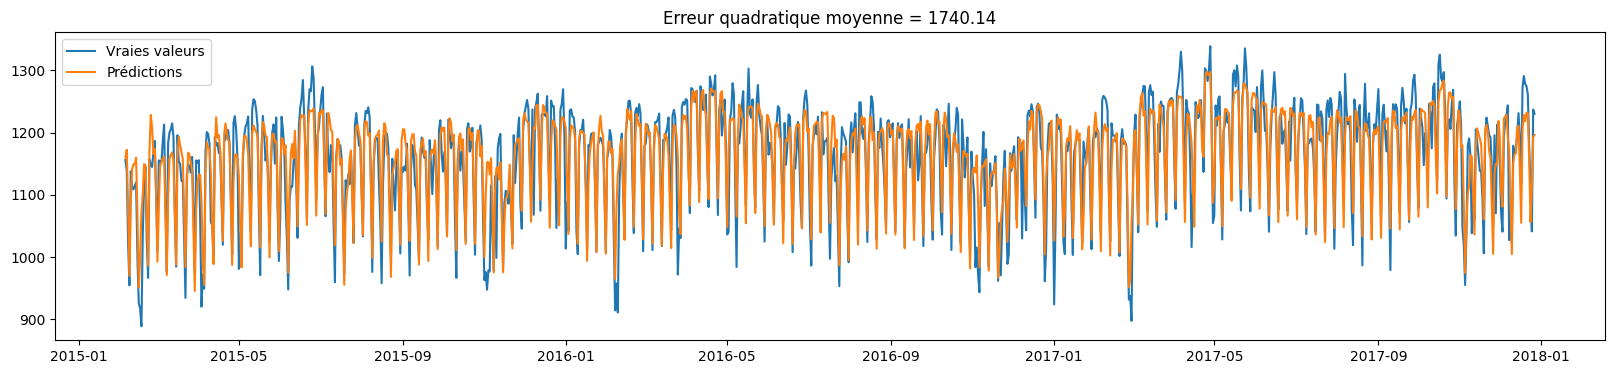

In [22]:
plot_true_pred(model_early_stopping, dataset_train)

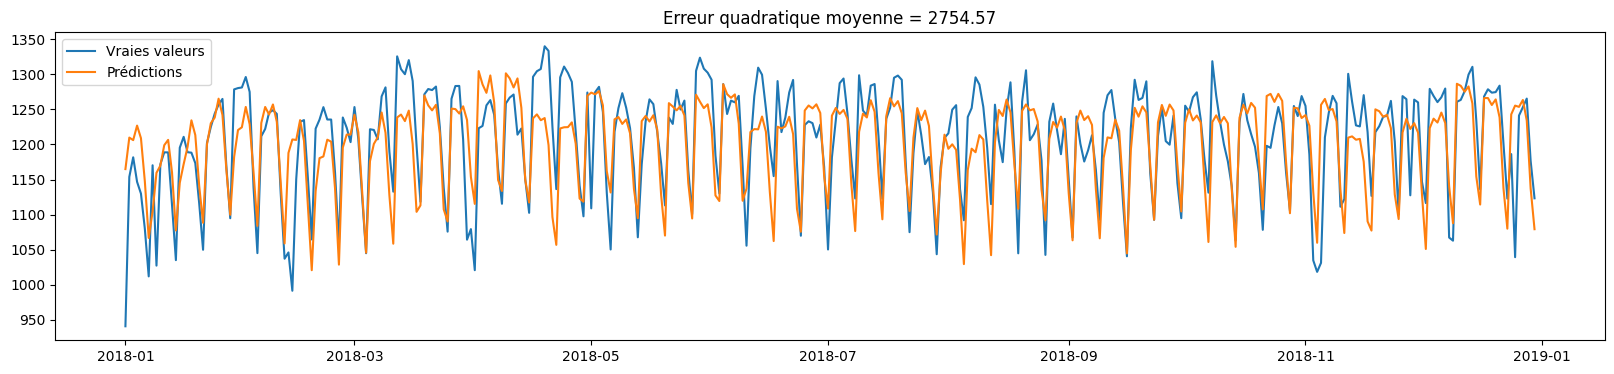

In [23]:
plot_true_pred(model_early_stopping, dataset_val)

On remarque également que le modèle final, quand l'*early stopping* a eu lieu, correspond à celui de la dernière époque, qui obtient une performance moins bonne que le modèle une autre époque précédente par définition.
Par définition, Lightning sauvegarde le modèle à la fin de chaque époque dans le répertoire `version_X/checkpoints`.
Il est possible de modifier ce comportement en utilisant à nouveau l'argument `callbacks` de l'instance de `Trainer` grâce à l'outil [lightning.pytorch.callbacks.ModelCheckpoint](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.ModelCheckpoint.html) en lui fournissant quel score surveiller.
On utilise le même score que pour l'*early stopping*, c'est-à-dire la fonction de perte sur le jeu de validation.

Exécutez le code ci-dessous :

In [24]:
from lightning.pytorch.callbacks import ModelCheckpoint


model_early_stopping_best_checkpoint = RecurrentNeuralNetwork()

trainer_early_stopping_best_checkpoint = L.Trainer(
    max_epochs=100,
    enable_model_summary=False,  # supprimer le résumé du modèle
    logger=CSVLogger('.'),  # sauvegarder les résultats dans un fichier CSV
    num_sanity_val_steps=0,  # ne pas effectuer d'étape de validation avant l'entraînement
    callbacks=[
        TQDMProgressBar(refresh_rate=0),  # supprime la barre de progression
        EarlyStopping(monitor="loss_val", mode="min", patience=3),  # effectue de l'early stopping
        ModelCheckpoint(monitor="loss_val")  # sauvegarde le modèle avec la "loss_val" la plus faible
    ],
    log_every_n_steps=0,  # on ne sauvegarde les résultats qu'à la fin de chaque époque
)

trainer_early_stopping_best_checkpoint.fit(
    model=model_early_stopping_best_checkpoint,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)

Version 2


Époque 1 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.14470      |  7358.24  |
|  Validation  |      0.13737      |  6985.21  |
------------------------------------------------


Époque 2 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.13283      |  6754.37  |
|  Validation  |      0.13656      |  6944.23  |
------------------------------------------------


Époque 3 / 100
------------------------------------------------
|     Jeu      | Fonction de perte |    MSE    |
| ------------ | ----------------- | --------- |
| Entraînement |      0.10819      |  5501.54  |
|  Validation  |      0.10248      |  5210.89  |
------------------------------------------------


Époque 4 / 100
----------------------------------------

### Question 6

Quand l'entraînement est terminé, allez dans le dossier `lightning_logs/version_X/checkpoints` (remplacez `X` par la version correspondant à ce modèle, normalement la dernière s'il s'agit du dernier modèle entraîné) et regardez le nom du fichier.
Il indique l'époque et le pas (le pas est le nombre d'itérations, soit le nombre d'époques multiplié par le nombre de lots du jeu d'entraînement) du modèle sauvegardé.
Vérifiez que le numéro de l'époque dans le fichier correspond bien au numéro de l'époque avec la plus faible fonction de perte (ou MSE, c'est identique ici) sur le jeu de validation.

> **Attention** : Lightning compte les époques à partir de $0$, mais l'affichage effectué compte les époques à partie de $1$ (car c'est plus naturel pour un humain de compter à partir de 1). Il est donc normal que le numéro de l'époque dans le fichier soit inférieur de 1 au numéro de la meilleure époque affiché dans la sortie.

Les paramètres entraînables du modèle sont toujours ceux de la dernière époque.
On charge les paramètres entraînables sauvegardés, qui donnent une meilleure performance sur le jeu de validation.

In [25]:
import os


# On identifie le numéro de la dernière version
version = max([
    int(folder.split('version_')[1])
    for folder in os.listdir(os.path.join('.', 'lightning_logs'))
    if folder.startswith('version')
])
# Sinon, on donne le numéro de la version
# version =

# On récupère le chemin du fichier
path = f'./lightning_logs/version_{version}/checkpoints'
file = os.listdir(path)[0]

# On charge les paramètres entraînables sauvegardés
model_early_stopping_best_checkpoint = RecurrentNeuralNetwork.load_from_checkpoint(
    os.path.join(path, file), weights_only=True, map_location=torch.device("cpu")
)

### Question 7

Choisissez le meilleur modèle sur le jeu de validation et évaluez-le sur le jeu d'évaluation.
Par curiosité, évaluez également les autres modèles.
Est-ce que le meilleur modèle sur le jeu de validation est également le meilleur modèle sur le jeu d'évaluation ?

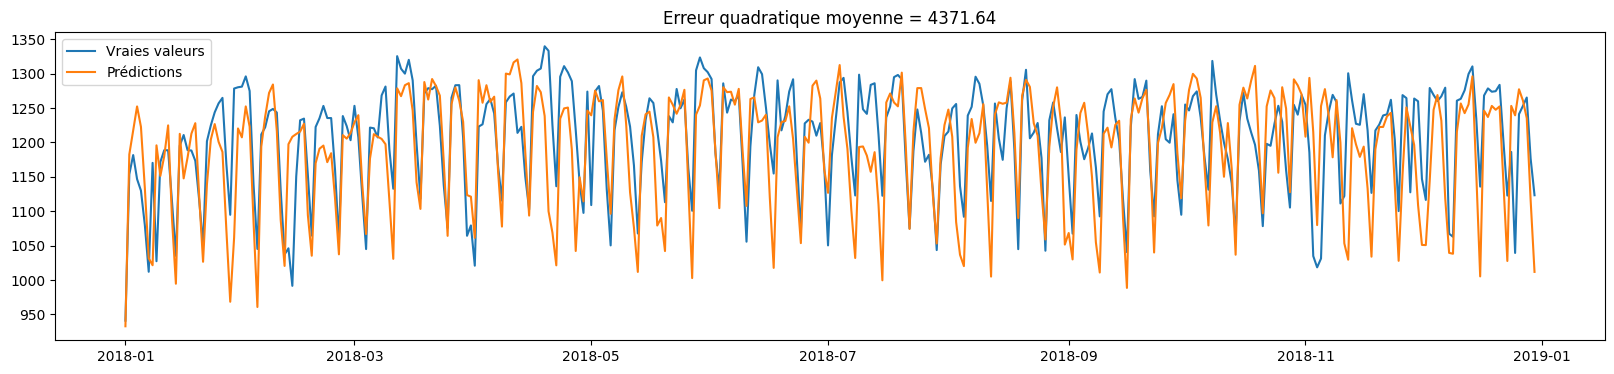

In [26]:
plot_true_pred(model, dataset_val)

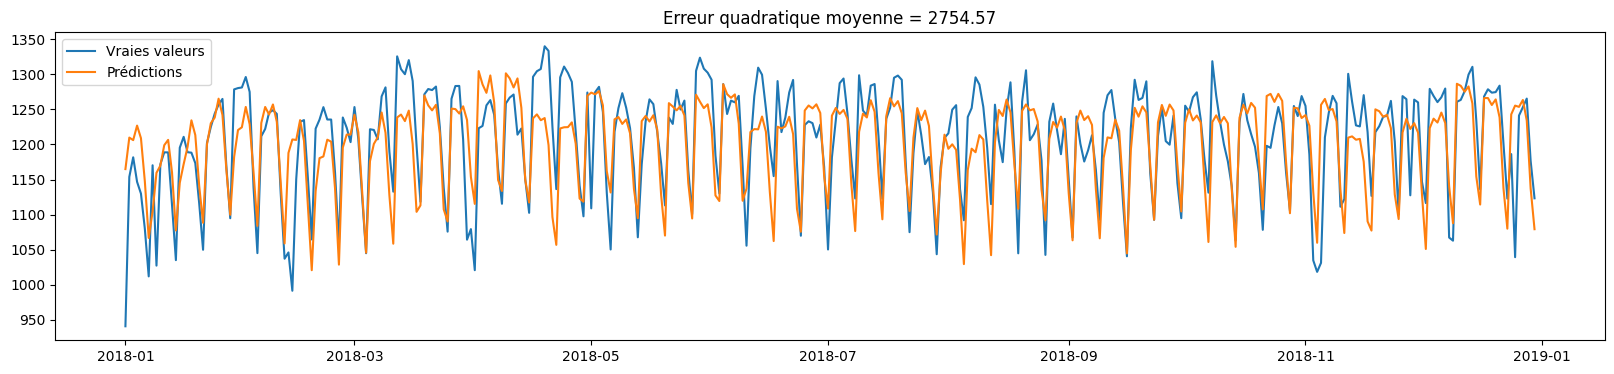

In [27]:
plot_true_pred(model_early_stopping, dataset_val)

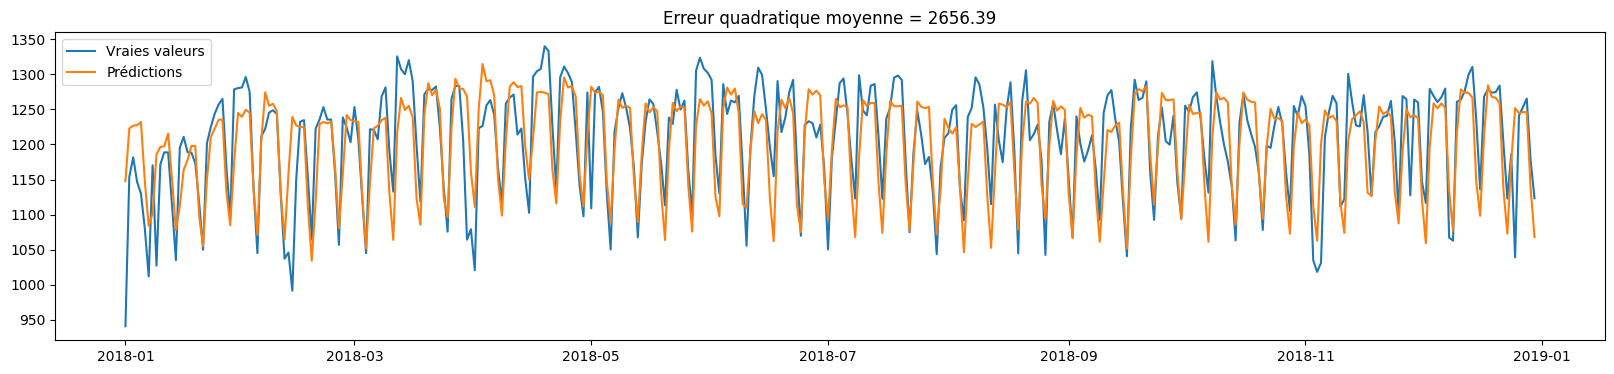

In [28]:
plot_true_pred(model_early_stopping_best_checkpoint, dataset_val)

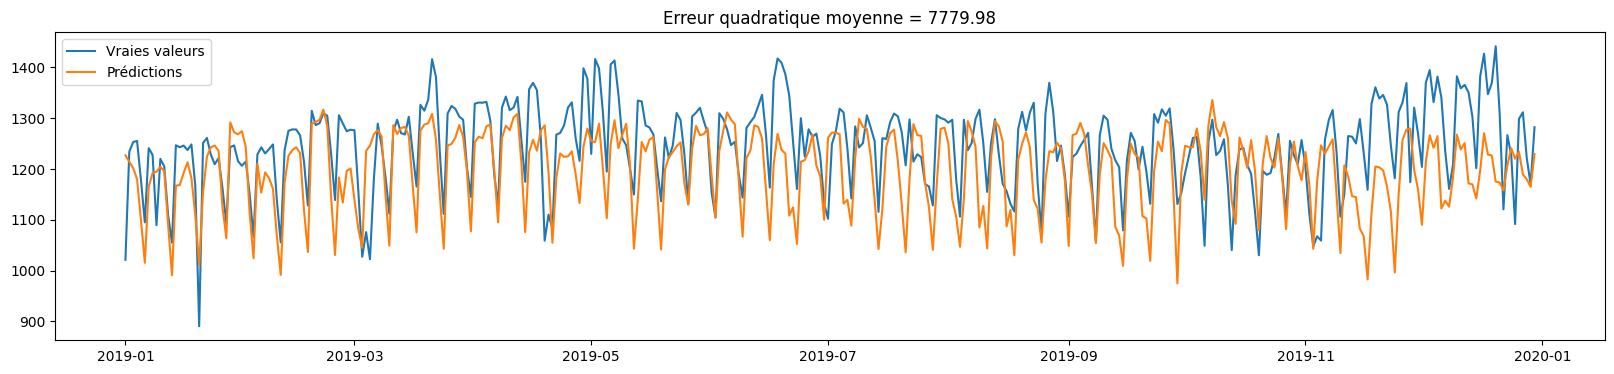

In [29]:
plot_true_pred(model, dataset_test)

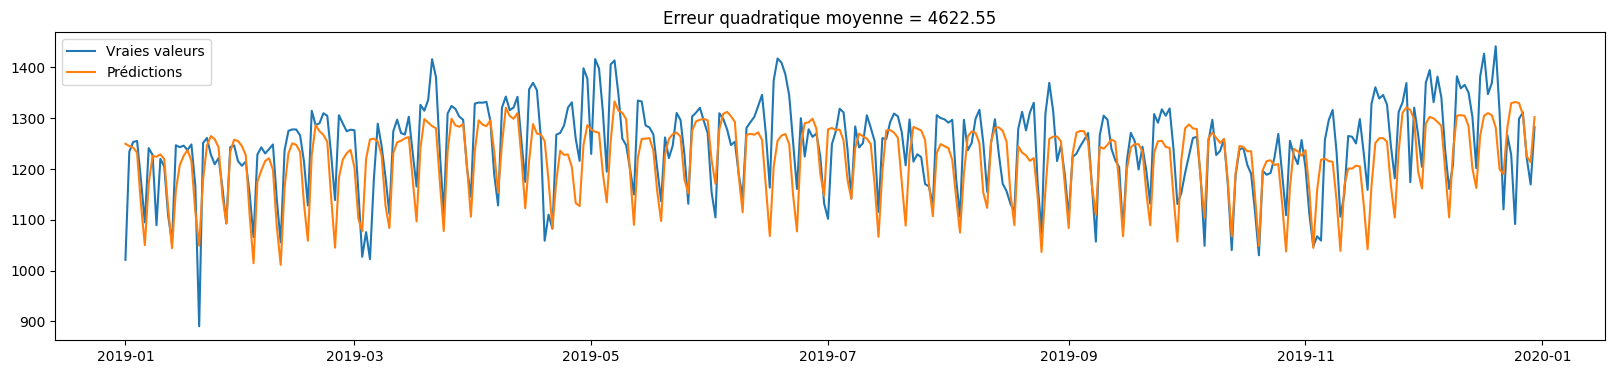

In [30]:
plot_true_pred(model_early_stopping, dataset_test)

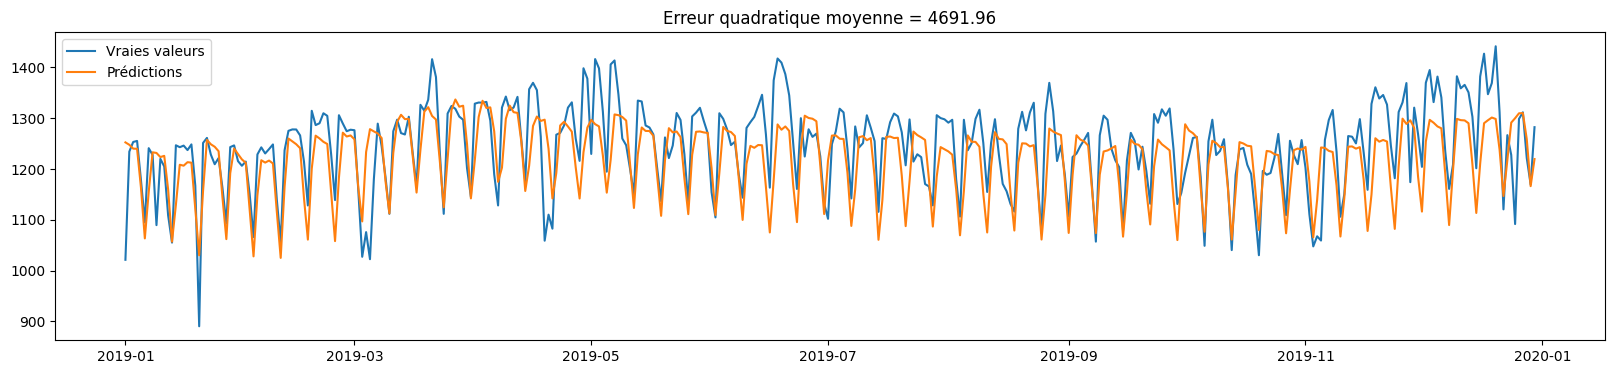

In [31]:
plot_true_pred(model_early_stopping_best_checkpoint, dataset_test)